# Hybrid Quantum Neural Networks 

The example below highlights a hybrid quantum neural network workflow with CUDA Quantum and Pytorch where both layers are GPU accelerated to maximise performance. 


<img src="images/hybrid.png" alt="hybrid" width="600">



We perform binary classification on the MNIST dataset where data flows through the neural network architecture to the quantum circuit whose output is used to classify hand written digits.

In [1]:
%pip install matplotlib torch torchvision

In [2]:
# Import the relevant packages

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

In [3]:
# GPU utilities

cudaq.set_target("nvidia")  # Set CUDAQ to run on GPU's

torch.cuda.is_available(
)  # If this is True then the NVIDIA drivers are correctly installed

torch.cuda.device_count()  # Counts the number of GPU's available

torch.cuda.current_device()

torch.cuda.get_device_name(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Training set.
sample_count = 140

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1.
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set.
sample_count = 70

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 72148113.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79537553.40it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 45882038.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15252625.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class QuantumFunction(Function):
    """This class defines the quantum circuit structure, the forward and the backward method."""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel
        self.theta = thetas
        self.hamiltonian = hamiltonian

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training.
        kernel.ry(thetas[0], qubits[0])
        kernel.rx(thetas[1], qubits[0])

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        expectation = torch.tensor(cudaq.observe(self.kernel, spin.z(0),
                                                 thetas.tolist()).expectation(),
                                   device=device)

        return expectation

In [6]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        expectation = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation)

        return expectation

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = (expectation_right -
                            expectation_left) / 2 * ctx.shift

        return gradients * grad_output.float(), None, None

In [7]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        # 1 qubit quantum circuit.
        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return ans

In [8]:
qubit_count = 1
hamiltonian = spin.z(0)
shift = torch.tensor(np.pi / 2)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(
            64, 2
        )  # Output a 2D tensor since we have 2 variational parameters in our quantum circuit.
        self.hybrid = QuantumLayer(
            qubit_count, hamiltonian, shift
        )  # Input is the magnitude of the parameter shifts to calculate gradients.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).reshape(
            -1
        )  # Reshapes required to satisfy input dimensions to CUDA Quantum.
        x = self.hybrid(x).reshape(-1)

        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [9]:
# We move our model to the CUDA device to minimise data transfer between GPU and CPU.

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in range(epochs):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # Batch training.
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass.
        output = model(data).to(device)

        # Calculating loss.
        loss = loss_func(output, target).to(device)

        # Backward pass.
        loss.backward()

        # Optimize the weights.
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

Training [5%]	Loss: -1.1656
Training [10%]	Loss: -1.3695
Training [15%]	Loss: -1.4121
Training [20%]	Loss: -1.4068
Training [25%]	Loss: -1.4315
Training [30%]	Loss: -1.4356
Training [35%]	Loss: -1.4486
Training [40%]	Loss: -1.4598
Training [45%]	Loss: -1.4571
Training [50%]	Loss: -1.4700
Training [55%]	Loss: -1.4790
Training [60%]	Loss: -1.4798
Training [65%]	Loss: -1.4854
Training [70%]	Loss: -1.4866
Training [75%]	Loss: -1.4916
Training [80%]	Loss: -1.4938
Training [85%]	Loss: -1.4896
Training [90%]	Loss: -1.4874
Training [95%]	Loss: -1.4941
Training [100%]	Loss: -1.4970


Text(0, 0.5, 'Neg Log Likelihood Loss')

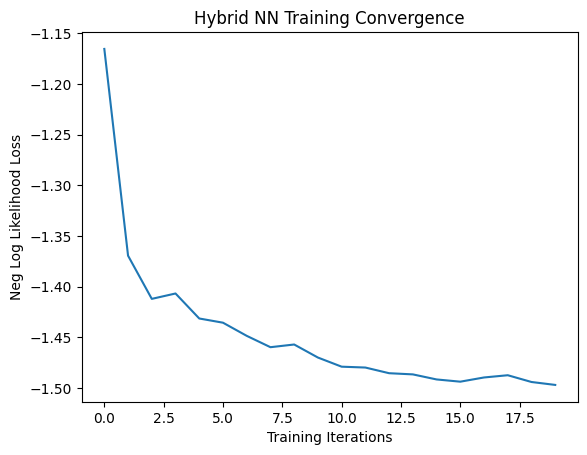

In [10]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")

In [11]:
# Testing on the test set.

model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))